<a href="https://colab.research.google.com/github/MShiloni22/Surp_RT_Project/blob/main/Project_1_Surprisals_and_RTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

The following code provides you with surprisal values for the same data you used in Homework 2.  The surprisal values are based on the output of an RNN model.

We leave it up to you to perform the alignment between the model output and the reading times!

Feel free to skim through the code, it might be helpful for the semi-structured and open-ended tasks!

## Set up dependencies and data

Run the cell below to fetch the recurrent neural network codebase we've designed for this assignment.

It will leave the files in a directory called `rnn` (check in the sidebar after you've run the command).

In [ ]:
%%bash
git clone https://github.com/scaperex/neural-complexity.git rnn
mkdir -p rnn/data/ptb

Cloning into 'rnn'...


## Mount Google Drive

We'll save your corpus data, model checkpoints, and output to Google Drive for safekeeping.

Follow the instructions in the output of this command to link your Drive account.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"

## Upload corpus files for LM training

Here we upload the Penn Treebank corpus files  to the `rnn/data/ptb` folder.
Your files should be named:

- `ptb_tok_train.txt`
- `ptb_tok_dev.txt`

In [ ]:
!wget -qO rnn/data/ptb/ptb_tok_train.txt https://gist.githubusercontent.com/omershubi/cdd4231472d6188f03ab21e2b2729fee/raw/e1b4c764561fd038470830534baaa220b0eb4c6d/ptb_tok_train.txt
!wget -qO rnn/data/ptb/ptb_tok_dev.txt https://gist.githubusercontent.com/omershubi/31eff71b74dfb8cfe93d1a9acf8ab523/raw/094d3094b06beb92cd7fd0496710cf43273f8c64/ptb_tok_dev.txt
!cp rnn/data/ptb/* "$GDRIVE_DIR/corpus_data/"

# Recurrent neural network modeling

## Train model

Now we're ready to begin training the model. The below command will launch the neural network optimization procedure, and progressively save checkpoints to the Google Drive you've just mounted. The neural network train for 40 epochs (1 epoch = 1 loop through the training dataset), which should take approximately **2 hours**.

Checkpoints will be saved each time the validation loss improves, and named `ptb_model.pt`. Watch the output of the command below to see how the model's train and validation perplexity improve over time.

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname ptb_tok_train.txt --validfname ptb_tok_dev.txt

Libraries loaded
Traceback (most recent call last):
  File "/content/rnn/main.py", line 567, in <module>
    val_loss = evaluate(val_data)
  File "/content/rnn/main.py", line 509, in evaluate
    return total_loss / data_source.flatten().size(0)
ZeroDivisionError: float division by zero


## Compute surprisals

Now we'll compute model surprisals for the text data in `brown.txt` (already downloaded for you). This will output a file called `rnn_surprisals.tsv` to your Google Drive, which you'll use in the next steps of the analysis.

We'll load the checkpoint and use it to extract per-token surprisal estimates.

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model.pt"

In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/rnn_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


Cool, let's check that the surprisal output looks right. (Compare with the ngram model surprisals from before.)

In [ ]:
import pandas as pd
rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals.tsv',sep=' ')
rnn_surprisals

,word,sentid,sentpos,wlen,surp,entropy,entred
0,In,0,0,2,4.856478,10.964885,0.000000
1,<unk>,0,1,5,6.583270,7.420612,3.544273
2,County,0,2,6,16.290915,6.240435,1.180177
3,<unk>,0,3,5,8.326239,4.629838,1.610596
4,near,0,4,4,13.400445,7.827211,0.000000
...,...,...,...,...,...,...,...
7229,as,363,15,2,8.835321,1.217064,7.451658
7230,a,363,16,1,3.604601,8.731340,0.000000
7231,leader,363,17,6,11.114964,11.198640,0.000000
7232,and,363,18,3,5.478402,8.297466,2.901174


## Harmonize RNN surprisal and RT data

Load and align the reading times with the n-gram model surprisals.
You may load the harmonized csv from Homework 2, or align it again.

Finallyy, align the RNN model-derived surprisal values with human reading times. The harmonize function you wrote in Homework 2 may be helpful here too.

Note, modifications may be required as the tokenization is not necessarily the same as the n-gram model.

In [ ]:


import numpy as np
import statsmodels.api as sm
import pandas as pd

import re
from scipy import interpolate

def preprocess_token(token):
    # Remove non-alphanumeric characters
    token = re.sub(r'[^A-Za-z0-9]+', '', token)

    # Lowercase the token
    token = token.lower()

    return token

def harmonize(rt_data, surprs_data, irrelevant_columns):
    # Preprocess the word/token column in the RT data
    rt_data['word'] = rt_data['word'].apply(preprocess_token)

    # Preprocess the token column in the surprisal data
    surprs_data['word'] = surprs_data['word'].apply(preprocess_token)

    # Group the DataFrame by the 'word' column and calculate the mean of the 'time' column
    grouped = rt_data.groupby('word')['time'].mean().reset_index()

    # Merge the two dataframes on the preprocessed word/token column
    merged_data = pd.merge(grouped, surprs_data, left_on='word', right_on='word', how='left')

    # Remove the token column
    merged_data.drop(columns=irrelevant_columns, inplace=True)

    return merged_data


sprt = pd.read_csv('https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code')
sprt


irrelevant_columns = ['sentid',	'sentpos',	'wlen',	'entropy',	'entred']
harmonized_df_rnn = harmonize(sprt, rnn_surprisals, irrelevant_columns)
harmonized_df_rnn = harmonized_df_rnn.dropna()



harmonized_df_rnn.to_csv("harmonized_rnn.csv", index=False)
harmonized_df_rnn

,word,time,surp
1,100,305.373947,10.338896
2,100,305.373947,12.556079
3,1000,329.292105,14.012762
4,130,373.412632,12.537564
5,15,278.493158,13.558042
...,...,...,...
6417,your,280.882857,11.005460
6418,your,280.882857,11.218933
6419,your,280.882857,12.204559
6421,yourself,282.184242,15.425352


##Compare n-gram and RNN models


In [ ]:
# Load n-gram data from csv file (computed in HW2)
data_ngram = pd.read_csv("/content/gdrive/MyDrive/096222_project_surprisals_and_rts/harmonized_ngram.csv")  # Change URL as neccesary
data_ngram

,word,time,surprisal
0,100,305.373947,11.89690
1,100,305.373947,12.94430
2,1000,329.292105,8.33933
3,130,373.412632,13.56620
4,15,278.493158,13.06960
...,...,...,...
5958,your,280.882857,12.24340
5959,your,280.882857,12.89770
5960,your,280.882857,9.52563
5961,yourself,282.184242,16.21590


### Compare surprisal estimates to RTs

For each model, we will fit a linear regression model to predict RTs from the surprisal:

In [ ]:
import statsmodels.api as sm

# RNN

# Extract the predictor variable (surprisal) and the response variable (RT)
X = harmonized_df_rnn['surp']
y = harmonized_df_rnn['time']

# Fit OLS (ordinary least squares) model to predict RT from the surprisal
X = sm.add_constant(X)  # Add intercept to the model
lin_model = sm.OLS(y, X).fit()

print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     390.3
Date:                Sun, 02 Jul 2023   Prob (F-statistic):           5.54e-84
Time:                        08:16:59   Log-Likelihood:                -26888.
No. Observations:                5499   AIC:                         5.378e+04
Df Residuals:                    5497   BIC:                         5.379e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        292.9518      0.994    294.725      0.0

In [ ]:
# n-gram

# Extract the predictor variable (surprisal) and the response variable (RT)
X = data_ngram['surprisal']
y = data_ngram['time']

# Fit OLS (ordinary least squares) model to predict RT from the surprisal
X = sm.add_constant(X)  # Add intercept to the model
lin_model = sm.OLS(y, X).fit()

print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     427.2
Date:                Sun, 02 Jul 2023   Prob (F-statistic):           1.01e-91
Time:                        08:17:03   Log-Likelihood:                -30104.
No. Observations:                5963   AIC:                         6.021e+04
Df Residuals:                    5961   BIC:                         6.023e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        295.3423      1.161    254.288      0.0

To determine which model has surprisal estimates that correlate better with human reading times, we can compare the R-squared values of the linear regression models fitted to each dataset. The higher the R-squared value, the better the correlation between the predictor (surprisal) and the dependent variable (reading times).

According to the provided results, the R-squared value for the RNN model is 0.065, while the R-squared value for the n-gram model is 0.067. Although both values are relatively low, the n-gram model has a slightly higher R-squared value.

Therefore, based on the R-squared values, **the n-gram model's surprisal estimates correlate slightly better with human reading times compared to the RNN model**.

### Plot the relationship between surprisal estimates

Now, we would like to plot the relationship between the n-gram model's surprisal estimate for a word and the RNN's estimate.

Each point in the graph will correspond to a single token from
the harmonized data.

First, we will use the `pd.merge()` function to perform the inner join on the 'word' column of both datasets. The resulting dataframe should contain words that are present in both the RNN and n-gram datasets.

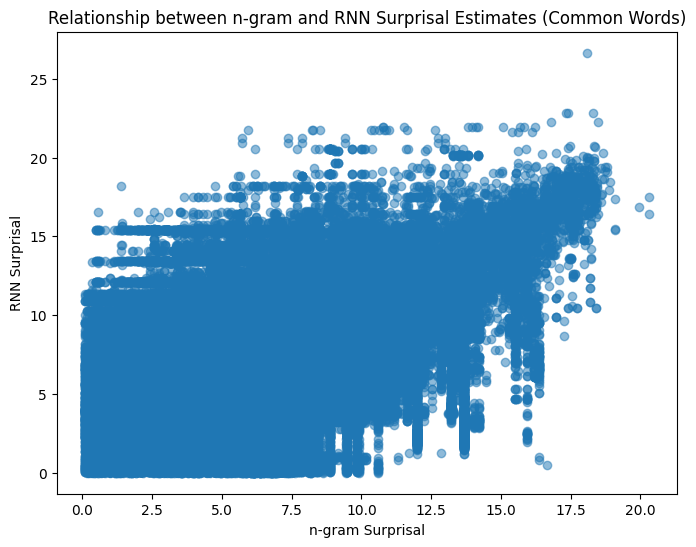

In [ ]:
import matplotlib.pyplot as plt

# Perform inner join on the word column
common_words_df = pd.merge(harmonized_df_rnn, data_ngram, on='word', how='left')
# Remove duplicate columns and rename columns
common_words_df = common_words_df.drop('time_y', axis=1)
common_words_df = common_words_df.rename(columns={'time_x': 'time', 'surp': 'rnn_surp', 'surprisal': 'ngram_surp'})


# Extract the surprisal values from the common dataset
common_ngram_surprisal = common_words_df['ngram_surp']
common_rnn_surprisal = common_words_df['rnn_surp']

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(common_ngram_surprisal, common_rnn_surprisal, alpha=0.5)
plt.title("Relationship between n-gram and RNN Surprisal Estimates (Common Words)")
plt.xlabel("n-gram Surprisal")
plt.ylabel("RNN Surprisal")
plt.show()

Based on the scatter plot, there are some observations we can see:



*   **Overall Trend**: There seems to be a positive correlation between the n-gram and RNN surprisal estimates. As the n-gram surprisal estimate increases, the RNN surprisal estimate generally tends to increase as well. However, the correlation is not perfectly linear, and there is a noticeable spread of data points around the trendline.
*   **Concentration of Points**: In some regions of the plot, there appears to be a higher concentration of data points. This suggests that certain ranges of surprisal estimates are more common in the data or are associated with specific patterns in the relationship between the two models. These ranges can be noticed especially in the interval [0, 10.0] in both n-gram and RNN.
*   **Outliers**: We can see that there are some outliers that deviate significantly from the general trend. These outliers represent words for which the n-gram and RNN models provide significantly different surprisal estimates. For example, a small amount of words were estimated with high surprisal from the RNN model (higher than 25) and lower values from the n-gram (around 14).
*   **Density**: The transparency applied to the data points provides a sense of density in regions with overlapping points. Areas with a higher density of points indicate a greater number of words with similar surprisal estimates from both models.

In general, we see that as we progress along one of the axes, there is a greater probability of seeing exceptions, which indicate gaps in the estimates of the surprisal values.





### Interesting points and relevant sentences

All interesting points correspond with the word 'john'.

After checking manually, here are the sentences in the `brown.txt` that contains the word 'john':

*   She was the **John** Harvey, one of those Atlantic sea-horses that had sailed to Bari to bring beans, bombs, and bullets to the U.S. Fifteenth Air Force, to Field Marshal Montgomery's Eighth Army then racing up the calf of the boot of Italy in that early December of 1943.
*   The **John** Harvey arrived in Bari, a port on the Adriatic, on November 28th, making for Porto Nuovo, which, as the name indicates, was the ancient city's new and modern harbor.
*   If anyone thought of the **John** Harvey, it was to observe that she was straddled by a pair of ships heavily laden with high explosive and if they were hit the **John** Harvey would likely be blown up with her own ammo and whatever else it was that she carried.
*   It had required the approval of President Franklin Delano Roosevelt before the **John** Harvey could be loaded with 100 tons of mustard gas and dispatched to the Italian warfront.
*   So the vile cargo went into the hole of the **John** Harvey.
*   Burlington aviator **John** J. Burns suggested the parade ground southwest of Fort Ethan Allen, and soon a dozen hastily-summoned National Guard pilots were bringing their wide-winged "Jenny" and DeHaviland two-seaters to rest on the frozen sod of the military base.
*   Nearly twenty-five years before, Captain **John** Davis had noted, as he sailed near the Arctic Circle, "a very great gulf, the water whirling and roaring, as it were the meeting of tides.

We can see that there is there is a difference between the models surprisal estimates (roughly 15) for every sentence. The models may have learned different contextual representations for the word 'john' based on the training data. The RNN model, with its recurrent structure, may be able to capture more nuanced and contextual information, whereas the n-gram model might rely on fixed-length patterns and struggle to capture long-range dependencies.

### Examine Spillover

We look at the relationship between word probability
and the next word's reading time.

In order to do so, we need to add information about the words' next word. We can get that from the original `rnn_surprisal` (see code in previous sections) and `ngram_surprisal`:

In [ ]:
def spillover(rt_data, surprs_data, irrelevant_columns):
    # Preprocess the word/token column in the RT data
    rt_data['word'] = rt_data['word'].apply(preprocess_token)

    # Preprocess the token column in the surprisal data
    surprs_data['word'] = surprs_data['word'].apply(preprocess_token)

    # Group the DataFrame by the 'word' column and calculate the mean of the 'time' column
    grouped = rt_data.groupby('word')['time'].mean().reset_index()

    # Add a column 'next_word_time', which shows the reading time of the next word
    grouped['next_word_time'] = grouped['time'].shift(1)

    # Merge the two dataframes on the preprocessed word/token column
    merged_data = pd.merge(grouped, surprs_data, left_on='word', right_on='word', how='left')

    # Remove the token column
    merged_data.drop(columns=irrelevant_columns, inplace=True)

    # Remove rows with NaN values
    merged_data = merged_data.dropna()

    # Calculate raw probabilities from surprisal values
    merged_data['raw_probability'] = 2**(-merged_data['surprisal'])


    return merged_data

# Rename 'surp' column, to match with function's name
rnn_surprisals = rnn_surprisals.rename(columns={'surp': 'surprisal'})

# Load ngram_surprisal dataset (from HW2)
ngram_surprisals = pd.read_csv('https://gist.githubusercontent.com/omershubi/f19f77f5157f7ba7ea1adf72a72847da/raw/d5d553b1217ea70fe3261ce5d9a0532f29769817/5gram_surprisals.tsv', index_col=False, sep='\t')
# Rename 'token' column, to match with function's name
ngram_surprisals = ngram_surprisals.rename(columns= {'token': 'word'})

rnn_spillover_data = spillover(sprt, rnn_surprisals, ['sentid',	'sentpos', 'wlen', 'entropy',	'entred'])
ngram_spillover_data = spillover(sprt, ngram_surprisals, ['sentence_id', 'token_id'])

Once we have the relevant information gathered in datasets, we can examine the spillover effect. We will perform the analysis based on the steps we did in HW2.

#### Fit a linear regression model to predict RTs from the surprisal

In [ ]:
# RNN

# Extract the predictor variable (raw_probability) and the response variable (next_word_time)
X = rnn_spillover_data['raw_probability']
y = rnn_spillover_data['next_word_time']

# Fit OLS (ordinary least squares) model to predict next_word_time from the raw_probability
X = sm.add_constant(X)  # Add intercept to the model
lin_model = sm.OLS(y, X).fit()

print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:         next_word_time   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     13.64
Date:                Sun, 02 Jul 2023   Prob (F-statistic):           0.000223
Time:                        08:18:13   Log-Likelihood:                -31189.
No. Observations:                5499   AIC:                         6.238e+04
Df Residuals:                    5497   BIC:                         6.239e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             332.9253      1.002    3

In [ ]:
# n-gram

# Extract the predictor variable (surprisal) and the response variable (RT)
X = ngram_spillover_data['raw_probability']
y = ngram_spillover_data['next_word_time']

# Fit OLS (ordinary least squares) model to predict RT from the surprisal
X = sm.add_constant(X)  # Add intercept to the model
lin_model = sm.OLS(y, X).fit()

print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:         next_word_time   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     9.655
Date:                Sun, 02 Jul 2023   Prob (F-statistic):            0.00190
Time:                        08:18:18   Log-Likelihood:                -33648.
No. Observations:                5963   AIC:                         6.730e+04
Df Residuals:                    5961   BIC:                         6.731e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             330.2150      0.936    3

#### Plot the relationship between word's probability and the next word's reading time

Without Binning:


1.   RNN
2.   ngram



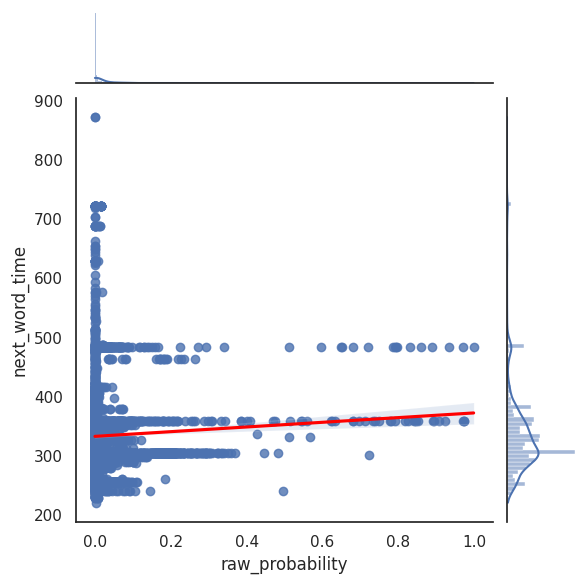

In [ ]:
import seaborn as sns; sns.set(style="white", color_codes=True)

g = sns.jointplot(x="raw_probability", y="next_word_time", data=rnn_spillover_data, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

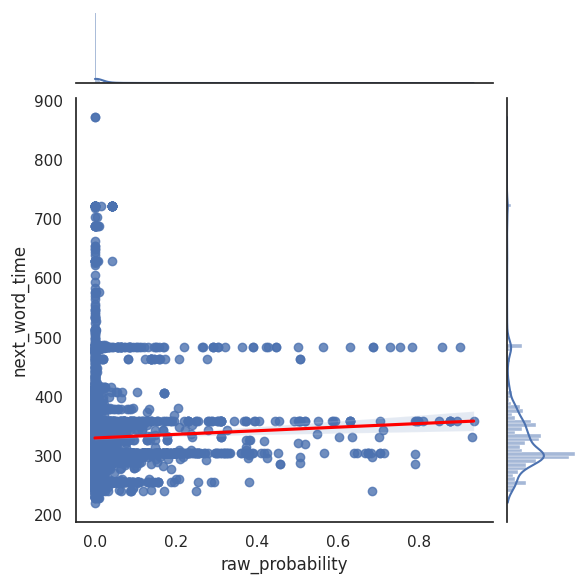

In [ ]:
g = sns.jointplot(x="raw_probability", y="next_word_time", data=ngram_spillover_data, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

With Binning:


1.   RNN
2.   ngram



(250.0, 350.0)

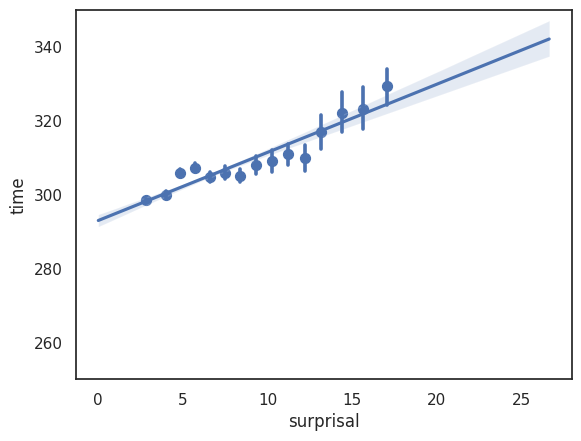

In [ ]:
g = sns.regplot(x="surprisal", y="time", data=rnn_spillover_data, x_bins=15)
g.set_ylim([250, 350])

(250.0, 350.0)

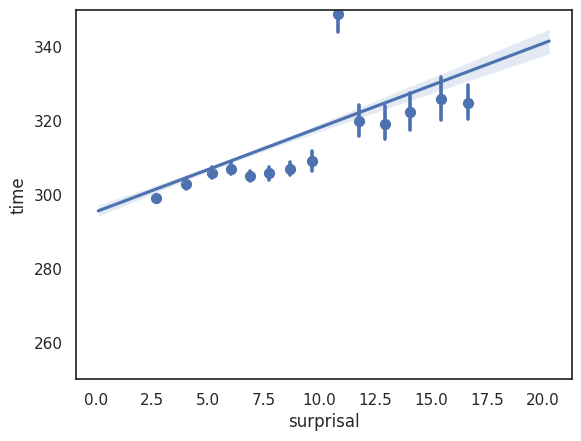

In [ ]:
g = sns.regplot(x="surprisal", y="time", data=ngram_spillover_data, x_bins=15)
g.set_ylim([250, 350])

#### Results Interpretation and Conclusions



Based on the regression results we can examine the spillover effects in the two models and compare them:

*For the RNN model:*


*   The coefficient of the "raw_probability" predictor (word probability) is 16.7013. This indicates that, on average, a one-unit increase in word probability (surprisal) is associated with an increase of 16.7013 units in the reading time of the next word.
*   The R-squared value is 0.001, suggesting that the word probability explains a very small proportion of the variance in the reading time of the next word.
*   The p-value for the coefficient is 0.056, which is marginally above the commonly used significance level of 0.05. This indicates that the relationship between word probability and next-word reading time in the RNN model may not be statistically significant.

*For the n-gram model:*
*   The coefficient of the "raw_probability" predictor is 30.5334. This suggests that, on average, a one-unit increase in word probability (surprisal) is associated with an increase of 30.5334 units in the reading time of the next word.
*   The R-squared value is 0.002, indicating that the word probability explains a slightly larger proportion of the variance in the reading time of the next word compared to the RNN model.
*   The p-value for the coefficient is 0.002, which is below the significance level of 0.05. This suggests that the relationship between word probability and next-word reading time in the n-gram model is statistically significant.



**In terms of comparing the spillover effects across the two models:**


*   The magnitude of the coefficients suggests that the spillover effect is larger in the n-gram model (30.5334) compared to the RNN model (16.7013). This indicates that the impact of word probability on the reading time of the next word is stronger in the n-gram model.
*   However, it's important to note that the overall effects are relatively small, as indicated by the low R-squared values.
*   The statistical significance of the relationship between word probability and next-word reading time is marginally significant in the RNN model and statistically significant in the n-gram model.

Overall, **the spillover effects in both models show a positive relationship between word probability (surprisal) and the reading time of the next word. The effect is stronger in the n-gram model**, suggesting that the n-gram model may capture the spillover effect more effectively than the RNN model.

# Semi Structured Task 1



In [ ]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 96.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.


We decided to use rnn surprisal data as the data we will fit and plot the RT surprisal cerve based on.

Since the requirement was to refer to the frequency of the word as well as its length as influential parameters in the modeling, we pre-processed the table and added appropriate features.

In addition, to enable a better analysis of the sllipover and current word effects, we added features of the probability of the current word as well as the reading time of the next word to the information table.

We performed the calculations of these features similar to the method learned in HW 2.


In [ ]:

import numpy as np
import statsmodels.api as sm
import pandas as pd
from collections import Counter
import math
import re
from scipy import interpolate

def preprocess_token(token):
    # Remove non-alphanumeric characters
    token = re.sub(r'[^A-Za-z0-9]+', '', token)

    # Lowercase the token
    token = token.lower()

    return token


def spillover(rt_data, surprs_data, irrelevant_columns):
    # Preprocess the word/token column in the RT data
    rt_data['word'] = rt_data['word'].apply(preprocess_token)

    # Preprocess the token column in the surprisal data
    surprs_data['word'] = surprs_data['word'].apply(preprocess_token)

    # Group the DataFrame by the 'word' column and calculate the mean of the 'time' column
    grouped = rt_data.groupby('word')['time'].mean().reset_index()

    # Add a column 'next_word_time', which shows the reading time of the next word
    grouped['next_word_time'] = grouped['time'].shift(1)

    # Merge the two dataframes on the preprocessed word/token column
    merged_data = pd.merge(grouped, surprs_data, left_on='word', right_on='word', how='left')

    # Remove the token column
    merged_data.drop(columns=irrelevant_columns, inplace=True)

    # Remove rows with NaN values
    merged_data = merged_data.dropna()

    # Calculate word probabilities from surprisal values
    merged_data['word probability'] = 2**(-merged_data['surprisal'])


    return merged_data



sprt = pd.read_csv('https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code')



# Rename 'surp' column, to match with function's name
rnn_surprisals = rnn_surprisals.rename(columns={'surp': 'surprisal'})


rnn_spillover_data = spillover(sprt, rnn_surprisals, ['sentid',	'sentpos', 'entropy',	'entred'])


# Read the PTB dataset
with open('rnn/data/ptb/ptb_tok_train.txt') as f:
    tokens = f.read().split()

# Preprocess the tokens
tokens = [preprocess_token(token) for token in tokens]

# Count the frequency of each token
token_counts = Counter(tokens)


# Calculate the log-frequency for each word
log_frequencies = []
for word in rnn_spillover_data['word']:
    if word in token_counts:
        frequency = token_counts[word]
        frequency = float(frequency)
        log_frequency = math.log10(frequency)
    else:
        log_frequency = 0
    log_frequencies.append(log_frequency)

# Add the log-frequency column to the dataframe
rnn_spillover_data['log_frequency'] = log_frequencies

# Save the updated dataset
rnn_spillover_data.to_csv('rnn_with_all.csv', index=False)



The code fits and plots a General Additive Model (GAM) for the RT surprisal curve. It includes control variables for log-frequency and word length, taking into account their effects on reading time. The model also examines the spillover effect. The parameters in the GAM include log-frequency, word length, word probability, next word time, and surprisal. By plotting the RT surprisal curve, we can visualize how surprisal influences reading time, while considering the impact of log-frequency and word length. This analysis provides insights into the relationship between word surprisal and cognitive processes involved in language comprehension, including the spillover effect.

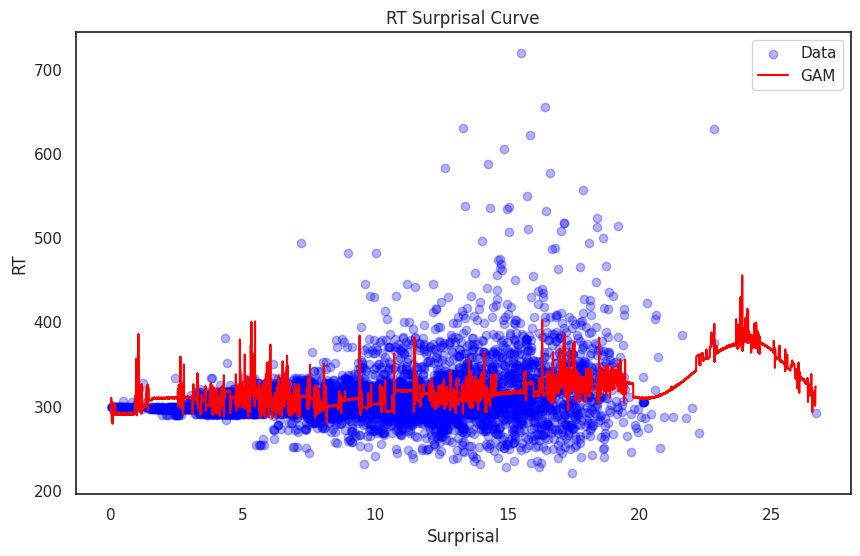

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     60.7868
Link Function:                     IdentityLink Log Likelihood:                                 -42610.496
Number of Samples:                         5499 AIC:                                            85344.5656
                                                AICc:                                           85345.9929
                                                GCV:                                              943.2924
                                                Scale:                                            924.5419
                                                Pseudo R-Squared:                                   0.1746
Feature Function                  Lam

<ipython-input-23-2c1f48db2848>:36: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam_model.summary())


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

merged_data = pd.read_csv('rnn_with_all.csv')


# Fit the GAM model with log-frequency, word length, and surprisal effects
X = merged_data[['log_frequency', 'wlen','word probability', 'next_word_time', 'surprisal']].values
y = merged_data['time'].values

# Fit the GAM model

gam_model = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4), lam = 0.6).fit(X, y)

## Generate a range of surprisal values
surprisal_values = np.linspace(min(X[:, 4]), max(X[:, 4]), num=len(X))


# Create a new data matrix with surprisal values
X_new = np.column_stack((X[:, :4], surprisal_values))

# Predict RT values using the GAM model
y_pred = gam_model.predict(X_new)

# Plot the RT surprisal curve
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 4], y, color='blue', alpha=0.3, label='Data')
plt.plot(surprisal_values, y_pred, color='red', label='GAM')
plt.xlabel('Surprisal')
plt.ylabel('RT')
plt.title('RT Surprisal Curve')
plt.legend()
plt.show()
print(gam_model.summary())




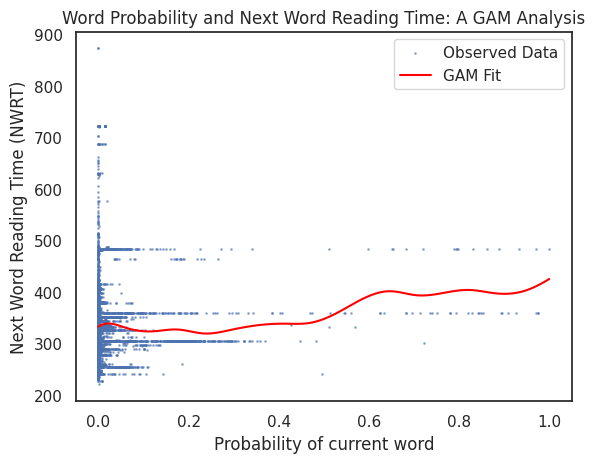

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.3019
Link Function:                     IdentityLink Log Likelihood:                                -51792.6539
Number of Samples:                         5499 AIC:                                           103611.9116
                                                AICc:                                           103611.981
                                                GCV:                                             4932.2605
                                                Scale:                                           4912.4032
                                                Pseudo R-Squared:                                   0.0106
Feature Function                  Lam

<ipython-input-24-4c92240a87d9>:24: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam_model.summary())


In [ ]:
# Extract relevant columns for the GAM model
X = merged_data['word probability'].values
y = merged_data['next_word_time'].values

# Fit the GAM model
gam_model = LinearGAM(s(0)).fit(X, y)

# Generate grid values for predictors
X_grid = gam_model.generate_X_grid(term=0, n=100)

# Predict the response variable using the fitted GAM model
y_pred = gam_model.predict(X_grid)

# Plot the connection between word probability and next word reading time
plt.scatter(merged_data['word probability'], merged_data['next_word_time'], alpha=0.5, label='Observed Data', s=1)
plt.plot(X_grid[:, 0], y_pred, color='red', label='GAM Fit')
plt.xlabel('Probability of current word')
plt.ylabel('Next Word Reading Time (NWRT)')
plt.legend()
plt.title('Word Probability and Next Word Reading Time: A GAM Analysis')
plt.show()

# Display the summary of the GAM model
print(gam_model.summary())

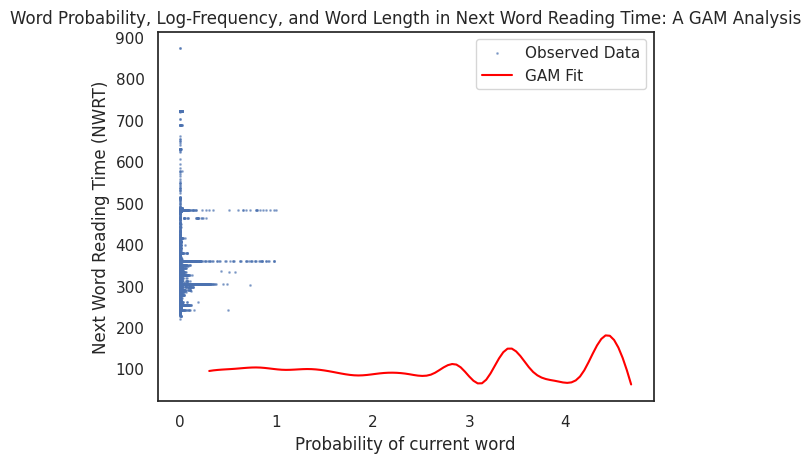

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     39.4322
Link Function:                     IdentityLink Log Likelihood:                                -50641.7783
Number of Samples:                         5499 AIC:                                           101364.4209
                                                AICc:                                          101365.0348
                                                GCV:                                             4036.7307
                                                Scale:                                           3984.6603
                                                Pseudo R-Squared:                                   0.2015
Feature Function                  Lam

<ipython-input-25-dbd70a6fe109>:25: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam_model.summary())


In [ ]:
# Extract relevant columns for the GAM model
X = merged_data[['log_frequency', 'wlen', 'word probability']].values
y = merged_data['next_word_time'].values


# Fit the GAM model
gam_model = LinearGAM(s(0)+s(1)+s(2)).fit(X, y)

# Generate grid values for predictors
X_grid = gam_model.generate_X_grid(term=0, n=100)

# Predict the response variable using the fitted GAM model
y_pred = gam_model.predict(X_grid)

# Plot the connection between word probability and next word reading time
plt.scatter(merged_data['word probability'], merged_data['next_word_time'], alpha=0.5, label='Observed Data', s=1)
plt.plot(X_grid[:, 0], y_pred, color='red', label='GAM Fit')
plt.xlabel('Probability of current word')
plt.ylabel('Next Word Reading Time (NWRT)')
plt.legend()
plt.title('Word Probability, Log-Frequency, and Word Length in Next Word Reading Time: A GAM Analysis')
plt.show()

# Display the summary of the GAM model
print(gam_model.summary())

# Semi-Structured Task 2

## Upload test file from Maze

In [ ]:
%%bash
mkdir -p "/content/gdrive/My Drive/096222_project_surprisals_and_rts/maze"
cd "/content/gdrive/My Drive/096222_project_surprisals_and_rts/maze"
wget https://raw.githubusercontent.com/vboyce/natural-stories-maze/master/Materials/for_ibex.txt

--2023-07-02 08:20:05--  https://raw.githubusercontent.com/vboyce/natural-stories-maze/master/Materials/for_ibex.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125533 (123K) [text/plain]
Saving to: ‘for_ibex.txt.7’

     0K .......... .......... .......... .......... .......... 40% 4.03M 0s
    50K .......... .......... .......... .......... .......... 81% 5.16M 0s
   100K .......... .......... ..                              100% 51.9M=0.02s

2023-07-02 08:20:05 (5.44 MB/s) - ‘for_ibex.txt.7’ saved [125533/125533]



## Transform test file

In order to be in a valid format to be considered as input for the RNN model, we need to align the test file in the same format as `brown.txt`.

In [ ]:
# Open the test file
with open('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/maze/for_ibex.txt', 'r') as file:
    lines = file.readlines()

# Remove square brackets, parentheses, numbers, and commas, and concatenate sentences
transformed_lines = []
for line in lines:
    line = line.strip()
    line = line.replace('[', '').replace(']', '').replace('(', '').replace(')', '').replace(',', '')
    line = ' '.join(line.split()[1:])  # Remove the numbers after '['
    transformed_lines.append(line)

# Join the transformed lines into a single string
transformed_text = ' '.join(transformed_lines)

# Save the transformed test file
with open('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/maze/test_file.txt', 'w') as file:
    file.write(transformed_text)

Now our test file is in the correct format, and we can copy it to the `rnn` directory:

In [ ]:
import shutil

# Define the source and destination paths
source_path = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/maze/test_file.txt'
destination_path = '/content/rnn/data/test_file.txt'

# Copy the file to the destination path
shutil.copyfile(source_path, destination_path)

'/content/rnn/data/test_file.txt'

## Compute surprisals

Now we'll compute model surprisals for the text data in `test_file.txt` (already downloaded for you). This will output a file called `maze_surprisals.tsv` to your Google Drive, which you'll use in the next steps of the analysis.

We'll load the checkpoint and use it to extract per-token surprisal estimates.

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model.pt"

In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'test_file.txt' --test --words --nopp > "$GDRIVE_DIR/maze_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


In [ ]:
maze_surprisals = pd.read_csv(f'{GDRIVE_DIR}/maze_surprisals.tsv',sep=' ')
maze_surprisals

,word,sentid,sentpos,wlen,surp,entropy,entred
0,<unk>,0,0,5,5.441895,10.964885,0.000000
1,you,0,1,3,12.800551,9.942103,1.022781
2,were,0,2,4,5.565341,9.706609,0.235495
3,to,0,3,2,5.190865,10.210282,0.000000
4,journey,0,4,7,19.480762,9.397016,0.813267
...,...,...,...,...,...,...,...
20507,<unk>,14,1826,5,11.712095,0.301419,3.332256
20508,prince,14,1827,6,19.275656,4.211013,0.000000
20509,constitute,14,1828,10,25.849529,0.076862,4.134151
20510,army,14,1829,4,17.477911,7.111670,0.000000


## Harmonize RNN-Maze surprisal and RT data

Now we'll upload the reading time data, so we can harmonize it with the surprisals. We'll bring the reading time data from the github repository. It can be found in the file `cleaned.rds`.

In [ ]:
! pip install pyreadr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 7.9 MB/s eta 0:00:00


In [ ]:
import requests
import pyreadr

file_url = 'https://github.com/vboyce/natural-stories-maze/raw/master/Data/cleaned.rds'
local_file_path = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/maze/cleaned.rds'

# Download the file
response = requests.get(file_url)
with open(local_file_path, 'wb') as file:
    file.write(response.content)

# Load the RDS file into a dataframe
result = pyreadr.read_r(local_file_path)
maze_rt = result[None]
maze_rt

,type,word_num,word,distractor,on_right,correct,rt,sentence,total_rt,age,...,q_time_prac_1,q_time_prac_2,q_time_1,q_time_2,q_time_3,q_time_4,q_time_5,q_time_6,num_correct,subject
0,practice,0,The,x-x-x,False,yes,3939,The main trees in coniferous forests are everg...,3939,50.0,...,6946,4647,13063,3222,8559,587,391,380,3,1
1,practice,1,main,gone,True,no,1913,The main trees in coniferous forests are everg...,3116,50.0,...,6946,4647,13063,3222,8559,587,391,380,3,1
2,practice,2,trees,forth,False,yes,1534,The main trees in coniferous forests are everg...,1534,50.0,...,6946,4647,13063,3222,8559,587,391,380,3,1
3,practice,3,in,yeah,True,yes,839,The main trees in coniferous forests are everg...,839,50.0,...,6946,4647,13063,3222,8559,587,391,380,3,1
4,practice,4,coniferous,profitably,True,yes,1482,The main trees in coniferous forests are everg...,1482,50.0,...,6946,4647,13063,3222,8559,587,391,380,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112535,critical8,26,featuring,processor,True,yes,944,"Although most now agree with this conclusion, ...",944,48.0,...,6541,6569,6539,3542,3479,4027,6238,2918,6,100
112536,critical8,27,prominent,liability,True,yes,2065,"Although most now agree with this conclusion, ...",2065,48.0,...,6541,6569,6539,3542,3479,4027,6238,2918,6,100
112537,critical8,28,UFOlogists,Quaternion,False,no,1319,"Although most now agree with this conclusion, ...",2359,48.0,...,6541,6569,6539,3542,3479,4027,6238,2918,6,100
112538,critical8,29,and,sell,False,yes,824,"Although most now agree with this conclusion, ...",824,48.0,...,6541,6569,6539,3542,3479,4027,6238,2918,6,100


Now we can harmonize:

In [ ]:
irrelevant_columns = ['sentid',	'sentpos',	'wlen',	'entropy',	'entred']

# Rename 'rt' to 'time', to fit with function
maze_rt = maze_rt.rename(columns={'rt': 'time'})

harmonized_maze = harmonize(maze_rt, maze_surprisals, irrelevant_columns)
harmonized_maze = harmonized_maze.dropna()

harmonized_maze.to_csv("harmonized_maze.csv", index=False)
harmonized_maze

,word,time,surp
0,a,1087.678919,5.335593
1,a,1087.678919,4.404162
2,a,1087.678919,8.572677
3,a,1087.678919,4.233988
4,a,1087.678919,3.717886
...,...,...,...
11286,your,615.146341,11.414866
11287,your,615.146341,16.727757
11288,your,615.146341,19.861881
11289,your,615.146341,17.178249


## RT-Surprisals Analysis

### Fit a linear regression model to predict RTs from the surprisal

In [ ]:
# Extract the predictor variable (surprisal) and the response variable (RT)
X = harmonized_maze['surp']
y = harmonized_maze['time']

# Fit OLS (ordinary least squares) model to predict RT from the surprisal
X = sm.add_constant(X)  # Add intercept to the model
lin_model = sm.OLS(y, X).fit()

print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     19.14
Date:                Sun, 02 Jul 2023   Prob (F-statistic):           1.22e-05
Time:                        08:21:50   Log-Likelihood:                -77850.
No. Observations:               10662   AIC:                         1.557e+05
Df Residuals:                   10660   BIC:                         1.557e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        769.4934      8.104     94.956      0.0

### Examine Spillover

We look at the relationship between word probability
and the next word's reading time.

In order to do so, we need to add information about the words' next word. We can get that from the original `maze_surprisals` (see code in previous sections):

In [ ]:
# Rename 'surp' column, to match with function's name
maze_surprisals = maze_surprisals.rename(columns={'surp': 'surprisal'})

maze_spillover_data = spillover(maze_rt, maze_surprisals, ['sentid',	'sentpos', 'wlen', 'entropy',	'entred'])

Once we have the relevant information gathered in datasets, we can examine the spillover effect. We will perform the analysis based on the steps we did so far.

#### Fit a linear regression model to predict RTs from the surprisal

In [ ]:
# Extract the predictor variable (raw_probability) and the response variable (next_word_time)
X = maze_spillover_data['word probability']
y = maze_spillover_data['next_word_time']

# Fit OLS (ordinary least squares) model to predict next_word_time from the raw_probability
X = sm.add_constant(X)  # Add intercept to the model
lin_model = sm.OLS(y, X).fit()

print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:         next_word_time   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     68.58
Date:                Sun, 02 Jul 2023   Prob (F-statistic):           1.37e-16
Time:                        08:23:43   Log-Likelihood:                -73504.
No. Observations:               10448   AIC:                         1.470e+05
Df Residuals:                   10446   BIC:                         1.470e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              873.5338      2.774  

#### Plot the relationship between word's probability and the next word's reading time

Without Binning:

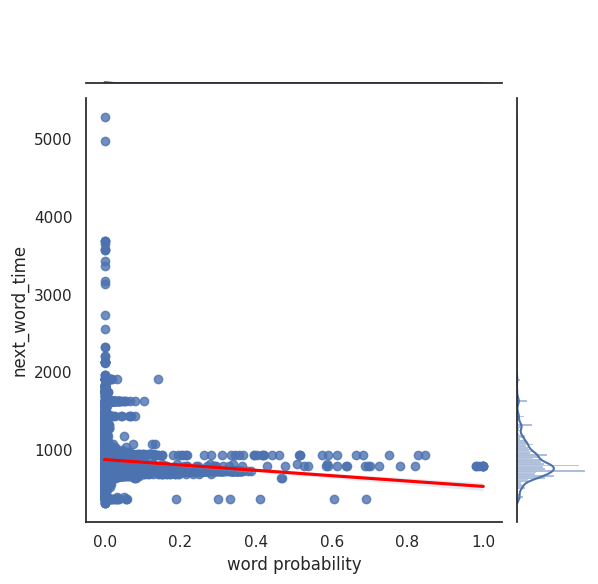

In [ ]:
import seaborn as sns; sns.set(style="white", color_codes=True)

g = sns.jointplot(x="word probability", y="next_word_time", data=maze_spillover_data, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

With Binning:

(250.0, 350.0)

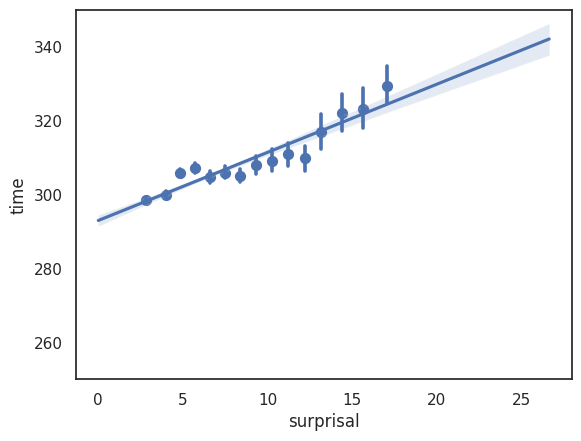

In [ ]:
g = sns.regplot(x="surprisal", y="time", data=rnn_spillover_data, x_bins=15)
g.set_ylim([250, 350])

## Results Interpretation and Conclusions: RT-Surprisals Relationship

***The results of the linear regression analysis (RT-Surprisals) are as follows:***

**R-squared**: The coefficient of determination (R-squared) is 0.002. It indicates that only 0.2% of the variability in the dependent variable (time) can be explained by the independent variable (surp). In other words, the model does not fit the data well, as the majority of the variation in the dependent variable is not accounted for by the independent variable.

**Adjusted R-squared**: The adjusted R-squared is also 0.002. It adjusts the R-squared value based on the number of predictors and the sample size. Since there is only one predictor in the model, the adjusted R-squared is the same as the R-squared value.

**F-statistic**: The F-statistic is 19.14. It tests the overall significance of the regression model. The associated probability (Prob (F-statistic)) is 1.22e-05, which is very small. This suggests that the model's explanatory power is statistically significant.

**Coefficients**: The coefficients represent the estimated effects of the variables in the model. In this case, there are two coefficients:


*   The constant term (intercept) is 769.4934. It represents the estimated mean value of the dependent variable when the independent variable is zero.
*   The coefficient for the independent variable "surp" is 2.4445. It indicates the estimated change in the dependent variable for a one-unit increase in the independent variable, holding other variables constant.

**Standard errors**: The standard errors measure the precision of the coefficient estimates. They represent the average amount by which the estimated coefficients vary across different samples. The standard error for the constant term is 8.104, and for the coefficient of "surp" is 0.559.

**t-statistics and p-values**: The t-statistic measures the ratio of the estimated coefficient to its standard error. The associated p-values assess the statistical significance of each coefficient. In this case, both the constant term and the coefficient for "surp" have p-values less than 0.05, indicating that they are statistically significant.

**Confidence intervals**: The 95% confidence intervals provide a range of values within which we can be 95% confident that the true population parameters lie. The confidence interval for the constant term ranges from 753.609 to 785.378, and for the coefficient of "surp" ranges from 1.349 to 3.540.

**Other statistics**: The output also includes additional statistics like the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC), which are used for model selection. The Durbin-Watson statistic tests for autocorrelation in the residuals, and the Jarque-Bera (JB) statistic tests for normality of the residuals.

**Overall, the results suggest that the linear regression model with surprisal estimates as the single predictor does not explain much of the variability in the reading times. The low R-squared value indicates that other factors not included in the model may have a stronger influence on the reading times**.

***The results of the linear regression analysis for the spillover effect are as follows:***

**R-squared**: The coefficient of determination (R-squared) is 0.007. It indicates that approximately 0.7% of the variability in the dependent variable (next_word_time) can be explained by the independent variable (raw_probability). In other words, the model explains a small portion of the variation in the dependent variable.

**Adjusted R-squared**: The adjusted R-squared is 0.006. It adjusts the R-squared value based on the number of predictors and the sample size. Since there is only one predictor in the model, the adjusted R-squared is the same as the R-squared value.

**F-statistic**: The F-statistic is 68.58. It tests the overall significance of the regression model. The associated probability (Prob (F-statistic)) is 1.37e-16, which is very small. This indicates that the model's explanatory power is statistically significant.

**Coefficients**: The coefficients represent the estimated effects of the variables in the model. In this case, there are two coefficients:


*   The constant term (intercept) is 873.5338. It represents the estimated mean value of the dependent variable when the independent variable (raw_probability) is zero.
*   The coefficient for the independent variable "raw_probability" is -345.6846. It indicates the estimated change in the dependent variable for a one-unit increase in the independent variable, holding other variables constant.

**Standard errors**: The standard errors measure the precision of the coefficient estimates. They represent the average amount by which the estimated coefficients vary across different samples. The standard error for the constant term is 2.774, and for the coefficient of "raw_probability" is 41.744.

**t-statistics and p-values**: The t-statistic measures the ratio of the estimated coefficient to its standard error. The associated p-values assess the statistical significance of each coefficient. In this case, both the constant term and the coefficient for "raw_probability" have p-values less than 0.05, indicating that they are statistically significant.

**Confidence intervals**: The 95% confidence intervals provide a range of values within which we can be 95% confident that the true population parameters lie. The confidence interval for the constant term ranges from 868.097 to 878.971, and for the coefficient of "raw_probability" ranges from -427.510 to -263.859.

**Other statistics**: The output also includes additional statistics like the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC), which are used for model selection. The Durbin-Watson statistic tests for autocorrelation in the residuals, and the Jarque-Bera (JB) statistic tests for normality of the residuals.

**Overall, the results indicate that the linear regression model with the single predictor "raw_probability" explains a small portion of the variation in the dependent variable "next_word_time" for the spillover effect. The negative coefficient suggests that higher raw probability values are associated with lower reading times for the next word. However, the model's overall explanatory power is still relatively weak**.

## Comparison to the ngram Model

***RT-Surprisal Relationship:***

**ngram:**


*   R-squared: 0.067
*   Coefficient for surprisal: 2.2741 (p < 0.001)

**RNN (Maze):**


*   R-squared: 0.002
*   Coefficient for surprisal: 2.4445 (p < 0.001)

In terms of the RT-Surprisal relationship, the **ngram model has a higher R-squared value** (0.067) compared to the RNN (Maze) model (0.002), **indicating a stronger association** between surprisal and reading time. **Both models show statistically significant** coefficients for surprisal (p < 0.001), suggesting that an increase in surprisal is associated with an increase in reading time.



***Spillover Effect (Raw Probability and Next_Word_RT Relationship):***

**ngram:**
*   R-squared: 0.002
*   Coefficient for raw_probability: 30.5334 (p = 0.002)

**RNN (Maze):**
*   R-squared: 0.007
*   Coefficient for raw_probability: -345.6846 (p < 0.001)

Regarding the spillover effect, both the ngram and RNN (Maze) models show statistically significant coefficients for raw_probability (p < 0.001). However, **the direction of the relationship differs between the models**. For the ngram model, a higher raw_probability is associated with a higher next_word_time. In contrast, the RNN (Maze) model indicates that a higher raw_probability is associated with a lower next_word_time.

**In summary, the ngram model demonstrates a stronger RT-Surprisal relationship compared to the RNN (Maze) model, as indicated by the higher R-squared value. For the spillover effect, the models exhibit different directions of the relationship between raw_probability and next_word_time. The ngram model shows a positive relationship, while the RNN (Maze) model shows a negative relationship.**

The comparison should be approached with caution due to the fact that the surprisal estimates for the Maze corpus were derived from an RNN model trained on a different corpus. Training an RNN model on one corpus and applying it to another corpus introduces potential disparities in linguistic patterns, which can impact the accuracy and generalizability of the surprisal estimates. Therefore, the observed relationships between surprisal and reading time should be interpreted considering the limitations and potential discrepancies arising from the use of an RNN model trained on a different corpus.

# Open-Ended Task: The Relationship Between RT, Surprisal and Emotion Detection

In this open-ended task, our objective is to investigate the relationship between reading time (RT), surprisal, and emotion detection. Although we do not have explicit emotion labels in our dataset, we aim to predict these labels using a BERT model and treat them as "true labels" for our analysis. Our approach involves using a pre-trained BERT model on available text data from Maze and using the predicted emotion labels as a proxy for the ground truth.

Next, we will examine the impact of RT and surprisal on the model's predictions. We will compare the performance of different models: one utilizing RT and surprisal as additional features and another without these features. By analyzing the differences in predictions, we can gain insights into the influence of RT and surprisal on emotion detection.

Through this investigation, we aim to shed light on the relationship between RT, surprisal, and the model's ability to detect emotions in the absence of explicit labels. This analysis has the potential to uncover valuable insights into the role of linguistic features in emotion detection tasks and enhance our understanding of the interplay between language processing and emotional responses.

## Step 1: Data Preprocessing

We chose to use the dataset cleaned.rds from the Maze project. This dataset contains 480 sentences that could be predicted for emotion detection.

To enlarge our dataset, we also used data from this article:
Frank, S.L., Fernandez Monsalve, I., Thompson, R.L. et al. Reading time data for evaluating broad-coverage models of English sentence processing. Behav Res 45, 1182–1190 (2013). https://doi.org/10.3758/s13428-012-0313-y.

With these two datasets we stand on 959 sentences.

### Load relevant datasets and texts

#### Maze

In [ ]:
! pip install pyreadr

In [ ]:
import requests
import pyreadr

file_url = 'https://github.com/vboyce/natural-stories-maze/raw/master/Data/cleaned.rds'
local_file_path = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/maze/cleaned.rds'

# Download the file
response = requests.get(file_url)
with open(local_file_path, 'wb') as file:
    file.write(response.content)

# Load the RDS file into a dataframe
result = pyreadr.read_r(local_file_path)
maze_rt = result[None]

In [ ]:
import os

# Transform the csv file maze_rt to a text, so we could use it for computing surprisals
text = ' '.join(maze_rt['sentence'].unique().tolist())

# Specify the file path to the rnn file
file_path = '/content/rnn/data/dataset.txt'

# Write the text string to the file
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'w') as file:
    file.write(text)

#### Additional reading time data

The relevant data for our task comes from two text files:


1.   stimuli - general information about the sentences
2.   selfpacedreading.RT - RT measures for words in each sentence (in the known format)



In [ ]:
import requests
import zipfile
import io
import os

# URL of the zip file
zip_url = "https://static-content.springer.com/esm/art%3A10.3758%2Fs13428-012-0313-y/MediaObjects/13428_2012_313_MOESM1_ESM.zip"

# Send a GET request to the URL to retrieve the zip file
response = requests.get(zip_url)

# Read the content of the zip file from the response
zip_content = io.BytesIO(response.content)

# Extract the zip file contents
with zipfile.ZipFile(zip_content, 'r') as zip_ref:
    # Specify the directory path where you want to save the extracted files
    extraction_path = '/content/rnn/data/additional'

    # Create the extraction directory if it doesn't exist
    os.makedirs(extraction_path, exist_ok=True)

    # Extract the files to the specified directory
    zip_ref.extractall(extraction_path)

In [ ]:
import pandas as pd

# Specify the path of your text file
stimuli = "/content/rnn/data/additional/stimuli.txt"

# Read the text file into a DataFrame
stimuli_df = pd.read_csv(stimuli, delimiter='\t', encoding='latin1')

In [ ]:
# Specify the path of your text file
spr_rt = "/content/rnn/data/additional/selfpacedreading.RT.txt"

# Read the text file into a DataFrame
spr_rt_df = pd.read_csv(spr_rt, delimiter='\t', encoding='latin1')

We need to create a dataset in a format similar to maze, so we'll merge the sentence column to the rt data.

In [ ]:
# Merge the datasets based on the "sent_nr" column
merged_spr_df = pd.merge(spr_rt_df, stimuli_df[['sent_nr', 'sentence']], on='sent_nr')
additional_df = merged_spr_df.rename(columns={'RT': 'rt'})

#### Create text files for computing surprisal

In [ ]:
import os

def create_text_file(dataset, file_path):
    # Transform the dataset to a text string
    text = ' '.join(dataset['sentence'].unique().tolist())

    # Write the text string to the file
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'w') as file:
        file.write(text)

maze_text = create_text_file(maze_rt, '/content/rnn/data/maze.txt')
additional_text = create_text_file(merged_spr_df, '/content/rnn/data/additional.txt')

### Compute Surprisals

We first need to compute surprisal values for each word in the dataset, and then average the reading times and surprisal for each sentence.

We will do the same process for both text files.

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model.pt"

In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'maze.txt' --test --words --nopp > "$GDRIVE_DIR/maze_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'additional.txt' --test --words --nopp > "$GDRIVE_DIR/additional_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


### Merge Surprisals with RTs Dataset and Average (per sentence)

In [ ]:
def compute_averaged_data(maze_rt_file, maze_surprisals_file):
    # Load tsv file with surprisal values to a csv file
    maze_surprisals = pd.read_csv(maze_surprisals_file, sep=' ')

    # Merge the datasets on a common column (e.g., 'word')
    merged_data = pd.merge(maze_rt, maze_surprisals[['word', 'surp']], on='word')

    # Calculate the average RT and average surp per sentence
    averaged_data = merged_data.groupby('sentence').agg({'rt': 'mean', 'surp': 'mean'}).reset_index()

    # Rename the columns
    averaged_data.columns = ['sentence', 'avg_rt', 'avg_surp']

    return averaged_data

maze_surprisals = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/maze_surprisals.tsv'  # Update with the actual file path
additional_surprisals = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/additional_surprisals.tsv'  # Update with the actual file path

averaged_data_1 = compute_averaged_data(maze_rt, maze_surprisals)
averaged_data_2 = compute_averaged_data(merged_spr_df, additional_surprisals)

preprocessed_data = pd.concat([averaged_data_1, averaged_data_2], ignore_index=True)

preprocessed_data

,sentence,avg_rt,avg_surp
0,"'Budge up,' Mom said, giving Abby a push with ...",890.548039,7.283937
1,"'But first, let me examine the head of this mo...",553.062243,3.658284
2,"'Come, let's join hands!' cried Aqua and becau...",633.018777,4.395233
3,'Do you think we would reward your cunning in ...,669.931756,6.757606
4,"'Except me!' cried a shrill, shrill voice, and...",580.759638,4.252904
...,...,...,...
954,Why had no one wanted to buy even one match?,459.897040,5.410574
955,"Within a few minutes, it wasn't an Elvis hairc...",401.044306,4.871892
956,You could hear the birds chirping and flapping...,863.495560,4.564658
957,You could've put an elephant in here last time...,881.245055,6.525347


## Step 2: Load the pre-trained BERT model - EmoRoBERTa

Since this task is focused on analyzing the effect of features on predictions rather than traditional emotion classification, we will use an emotion detection model with 28 labels. Reference to the model: https://huggingface.co/arpanghoshal/EmoRoBERTa

With these labels we will have our "ground truth" emotions that are expressed in our text.

In [ ]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.6 MB/s eta 0:00:00


In [ ]:
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline

# Load tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

# Create a pipeline
pipeline = pipeline('sentiment-analysis',
                    model='arpanghoshal/EmoRoBERTa')

# Create a list of sentences
sentences = preprocessed_data['sentence']

# Create a list of labels and predict the emotions for each sentence
emotion_labels_list = []
for sentence in sentences:
  emotion_labels = pipeline(sentence)
  emotion_labels_list.append(emotion_labels)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
# Add the 'labels' list as a new column in the 'averaged_data' dataset
preprocessed_data['label'] = emotion_labels_list
ground_truth_data = preprocessed_data

# Save the DataFrame to a CSV file
file_path = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/ground_truth_data.csv' # Change to your path
ground_truth_data.to_csv(file_path, index=False)

ground_truth_data

,sentence,avg_rt,avg_surp,label
0,"'Budge up,' Mom said, giving Abby a push with ...",890.548039,7.283937,"[{'label': 'neutral', 'score': 0.9913585186004..."
1,"'But first, let me examine the head of this mo...",553.062243,3.658284,"[{'label': 'neutral', 'score': 0.9882622361183..."
2,"'Come, let's join hands!' cried Aqua and becau...",633.018777,4.395233,"[{'label': 'neutral', 'score': 0.9174231290817..."
3,'Do you think we would reward your cunning in ...,669.931756,6.757606,"[{'label': 'disapproval', 'score': 0.839759349..."
4,"'Except me!' cried a shrill, shrill voice, and...",580.759638,4.252904,"[{'label': 'neutral', 'score': 0.9927576780319..."
...,...,...,...,...
954,Why had no one wanted to buy even one match?,459.897040,5.410574,"[{'label': 'curiosity', 'score': 0.52038490772..."
955,"Within a few minutes, it wasn't an Elvis hairc...",401.044306,4.871892,"[{'label': 'neutral', 'score': 0.5518506765365..."
956,You could hear the birds chirping and flapping...,863.495560,4.564658,"[{'label': 'neutral', 'score': 0.9897683858871..."
957,You could've put an elephant in here last time...,881.245055,6.525347,"[{'label': 'neutral', 'score': 0.9375668168067..."


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from transformers import AutoTokenizer, AutoModelForMaskedLM
import numpy as np
import ast
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_rel

ground_truth_data = pd.read_csv(file_path)

# Step 1: Prepare the data
sentences = ground_truth_data['sentence'].tolist()
labels = ground_truth_data['label'].tolist()
rt = ground_truth_data['avg_rt'].tolist()
surprisal = ground_truth_data['avg_surp'].tolist()

# Step 2: Split the data
train_sentences, val_test_sentences, train_labels, val_test_labels, train_rt, val_test_rt, train_surprisal, val_test_surprisal = train_test_split(
    sentences, labels, rt, surprisal, test_size=0.32, random_state=42)
val_sentences, test_sentences, val_labels, test_labels, val_rt, test_rt, val_surprisal, test_surprisal = train_test_split(
    val_test_sentences, val_test_labels, val_test_rt, val_test_surprisal, test_size=0.5, random_state=42)

# Preprocess labels
train_labels = [ast.literal_eval(label)[0]['label'] for label in train_labels]
val_labels = [ast.literal_eval(label)[0]['label'] for label in val_labels]
test_labels = [ast.literal_eval(label)[0]['label'] for label in test_labels]

# Create label-to-index mapping
unique_labels = set(train_labels + val_labels + test_labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Convert labels to numeric representation
train_labels = np.array([label_to_index[label] for label in train_labels])
val_labels = np.array([label_to_index[label] for label in val_labels])
test_labels = np.array([label_to_index[label] for label in test_labels])

# Step 3: Load pre-trained DistilRoBERTa model and tokenizer
distilroberta_model = AutoModelForMaskedLM.from_pretrained("distilroberta-base")
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

num_classes = len(unique_labels)

# Step 4: Tokenize and encode the sentences
def tokenize_sentences(sentences):
    tokenized_inputs = tokenizer.batch_encode_plus(
        sentences,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )
    return tokenized_inputs

train_tokenized = tokenize_sentences(train_sentences)
val_tokenized = tokenize_sentences(val_sentences)
test_tokenized = tokenize_sentences(test_sentences)

# Step 5: Define your downstream classifier model
class ClassifierModel(nn.Module):
    def __init__(self, distilroberta_model, num_classes):
        super(ClassifierModel, self).__init__()
        self.distilroberta = distilroberta_model
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(50265, num_classes)  # Adjust the number of output features


    def forward(self, inputs):
        outputs = self.distilroberta(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask']
        )
        last_hidden_state = outputs[0]
        pooled_output = last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.linear(pooled_output)

        return logits

class CustomDataset(Dataset):
    def __init__(self, data, labels, rt=None, surprisal=None):
        self.data = data
        self.labels = labels
        self.rt = rt
        self.surprisal = surprisal

    def __len__(self):
        return len(self.data['input_ids'])

    def __getitem__(self, index):
        input_ids = self.data['input_ids'][index]
        attention_mask = self.data['attention_mask'][index]
        label = self.labels[index]

        sample = {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}

        if self.rt is not None:
            sample['rt'] = self.rt[index]

        if self.surprisal is not None:
            sample['surprisal'] = self.surprisal[index]

        return sample


def train(model, train_data, train_labels, val_data, val_labels,name, num_epochs=10, batch_size=4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_loss[name] = []
    val_acc[name] = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr= ((1e-5)/2))

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            logits = model({'input_ids': input_ids, 'attention_mask': attention_mask})
            loss = criterion(logits, labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        train_loss[name].append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss}")

        model.eval()
        val_predictions = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                logits = model({'input_ids': input_ids, 'attention_mask': attention_mask})
                predictions = torch.argmax(logits, dim=1)
                val_predictions.extend(predictions.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_predictions)
        val_acc[name].append(val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy}")


def evaluate(model, data, labels, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    data_loader = DataLoader(data, batch_size=batch_size)

    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            logits = model({'input_ids': input_ids, 'attention_mask': attention_mask})
            batch_predictions = torch.argmax(logits, dim=1)
            predictions.extend(batch_predictions.cpu().numpy())

    accuracy = accuracy_score(labels, predictions)
    return accuracy

train_loss = {}
val_acc = {}


#Model 1: Sentence Only
print('Model 1: Sentence Only')
train_dataset = CustomDataset(train_tokenized, train_labels)
val_dataset = CustomDataset(val_tokenized, val_labels)
test_dataset = CustomDataset(test_tokenized, test_labels)


classifier_model_sentence = ClassifierModel(distilroberta_model, num_classes)
train(classifier_model_sentence, train_dataset, train_labels, val_dataset, val_labels, 'Sentence Only')
sentence_acc = evaluate(classifier_model_sentence, test_dataset, test_labels, batch_size=1)

print('Model 2: Sentence + Reading Time')
# Model 2: Sentence + ReadingTime
train_dataset_rt = CustomDataset(train_tokenized, train_labels, train_rt)
val_dataset_rt = CustomDataset(val_tokenized, val_labels, val_rt)
test_dataset_rt = CustomDataset(test_tokenized, test_labels, test_rt)

classifier_model_sentence_rt = ClassifierModel(distilroberta_model, num_classes)
train(classifier_model_sentence_rt, train_dataset_rt, train_labels, val_dataset_rt, val_labels, 'Sentence + Reading Time')
sentence_rt_acc = evaluate(classifier_model_sentence_rt, test_dataset_rt, test_labels, batch_size=1)

# Model 3: Sentence + Surprisal
print('Model 3: Sentence + Surprisal')
train_dataset_surprisal = CustomDataset(train_tokenized, train_labels, surprisal=train_surprisal)
val_dataset_surprisal = CustomDataset(val_tokenized, val_labels, surprisal=val_surprisal)
test_dataset_surprisal = CustomDataset(test_tokenized, test_labels, surprisal=test_surprisal)

classifier_model_sentence_surprisal = ClassifierModel(distilroberta_model, num_classes)
train(classifier_model_sentence_surprisal, train_dataset_surprisal, train_labels, val_dataset_surprisal, val_labels, 'Sentence + Surprisal')
sentence_surprisal_acc = evaluate(classifier_model_sentence_surprisal, test_dataset_surprisal, test_labels, batch_size=1)

# Model 4: Sentence + Reading Time + Surprisal
print('Model 4: Sentence + Reading Time + Surprisal')
train_dataset_all = CustomDataset(train_tokenized, train_labels, rt=train_rt, surprisal=train_surprisal)
val_dataset_all = CustomDataset(val_tokenized, val_labels, rt=val_rt, surprisal=val_surprisal)
test_dataset_all = CustomDataset(test_tokenized, test_labels, rt=test_rt, surprisal=test_surprisal)

classifier_model_all = ClassifierModel(distilroberta_model, num_classes)
train(classifier_model_all, train_dataset_all, train_labels, val_dataset_all, val_labels, 'Sentence + Reading Time + Surprisal')
all_acc = evaluate(classifier_model_all, test_dataset_all, test_labels, batch_size=1)







Model 1: Sentence Only
Epoch 1/10, Train Loss: 2.4250980830791353
Epoch 1/10, Validation Accuracy: 0.5490196078431373
Epoch 2/10, Train Loss: 1.8327343432815528
Epoch 2/10, Validation Accuracy: 0.5751633986928104
Epoch 3/10, Train Loss: 1.1498931480537347
Epoch 3/10, Validation Accuracy: 0.6601307189542484
Epoch 4/10, Train Loss: 0.5933104893364058
Epoch 4/10, Validation Accuracy: 0.7973856209150327
Epoch 5/10, Train Loss: 0.2345936197367571
Epoch 5/10, Validation Accuracy: 0.869281045751634
Epoch 6/10, Train Loss: 0.09388042200241378
Epoch 6/10, Validation Accuracy: 0.8823529411764706
Epoch 7/10, Train Loss: 0.06613488361293712
Epoch 7/10, Validation Accuracy: 0.869281045751634
Epoch 8/10, Train Loss: 0.03151296474274528
Epoch 8/10, Validation Accuracy: 0.8627450980392157
Epoch 9/10, Train Loss: 0.021057921985719222
Epoch 9/10, Validation Accuracy: 0.8823529411764706
Epoch 10/10, Train Loss: 0.010530740740568666
Epoch 10/10, Validation Accuracy: 0.869281045751634
Model 2: Sentence + R

In [ ]:
pip install tabulate

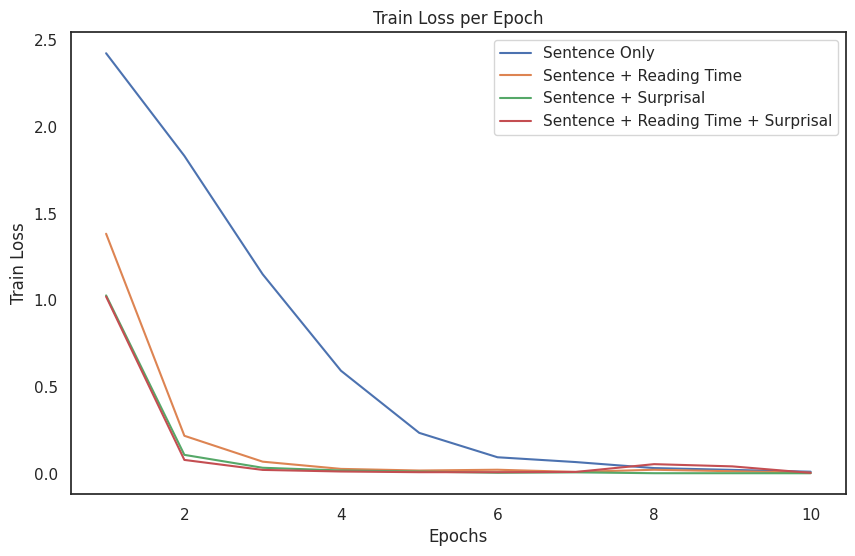

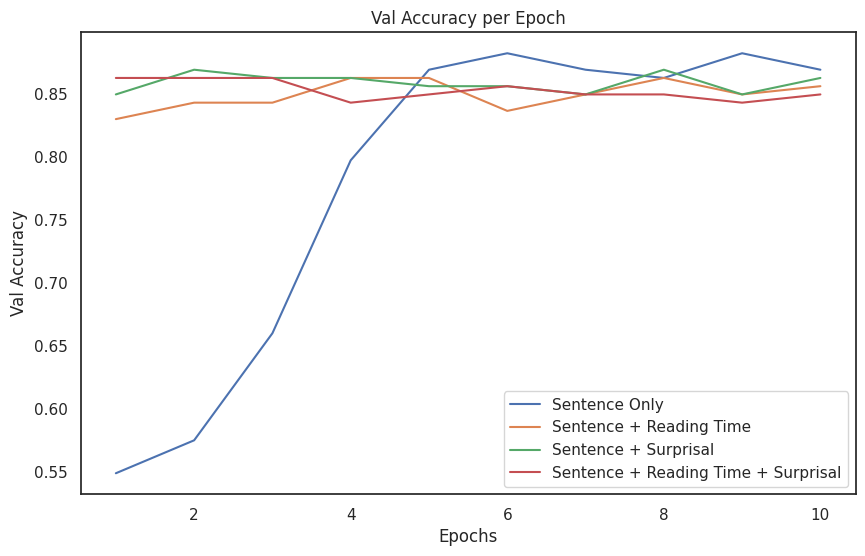

Accuracy on test set
Sentence Only accuracy: 0.8181818181818182
Sentence + RT accuracy: 0.8311688311688312
Sentence + Surprisal accuracy: 0.8246753246753247
Sentence + RT + Surprisal accuracy: 0.8116883116883117


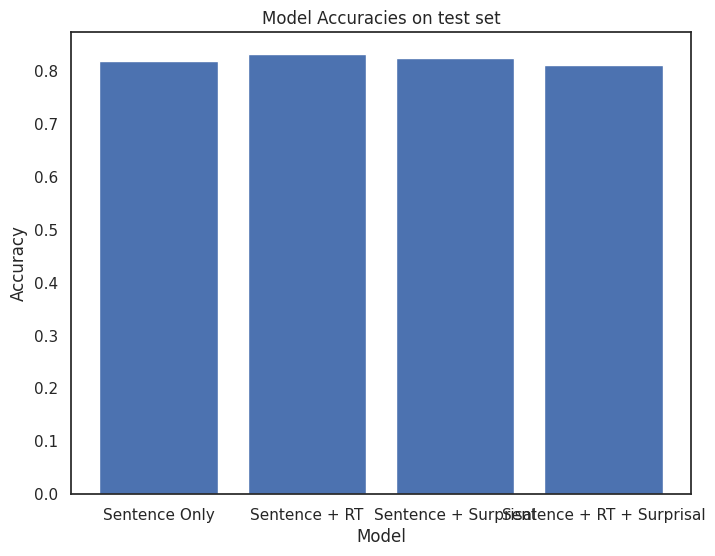

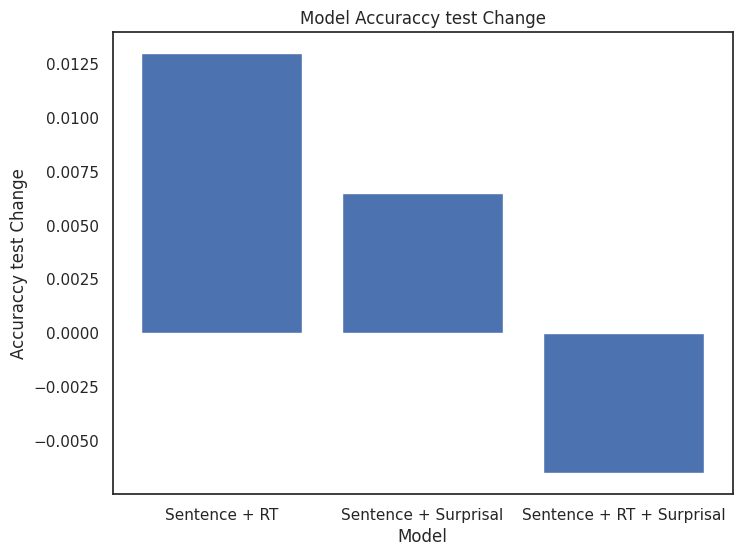

Accuracy on val set
Sentence Only accuracy: 0.8823529411764706
Sentence + RT accuracy: 0.8627450980392157
Sentence + Surprisal accuracy: 0.869281045751634
Sentence + RT + Surprisal accuracy: 0.8627450980392157


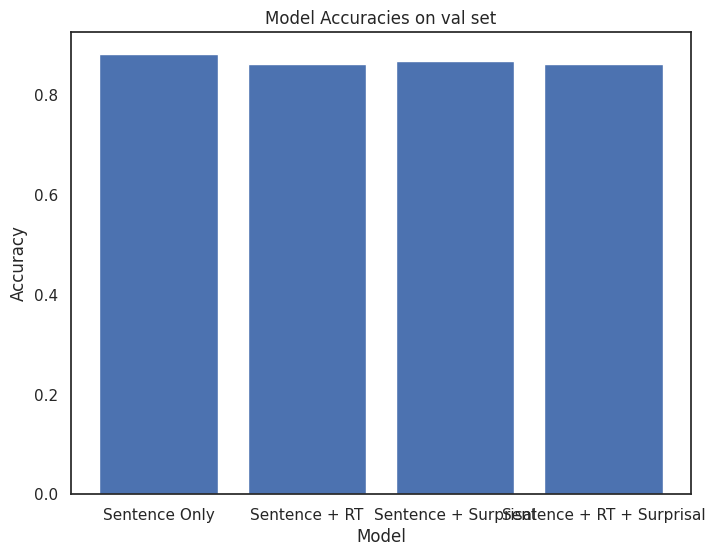

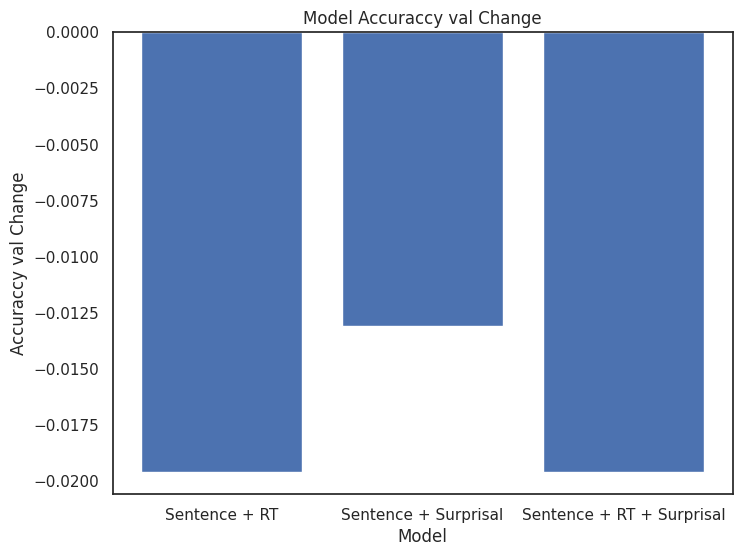

+-------------------------------------------------------------------+------------------------+
| Improvement                                                       | Value                  |
+===================================================================+========================+
|                                                                   | -0.0033104150751209205 |
+-------------------------------------------------------------------+------------------------+
|                                                                   | -0.0032891944656650574 |
+-------------------------------------------------------------------+------------------------+
|                                                                   | -0.013050674815380692  |
+-------------------------------------------------------------------+------------------------+
| Adding RT and surprisal does not significantly improve the model. |                        |
+-------------------------------------------------

In [ ]:
from tabulate import tabulate

epochs = range(1, len(train_loss[list(train_loss.keys())[0]]) + 1)

plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

for model_name, train_loss_vec in train_loss.items():
    plt.plot(epochs, train_loss_vec, label=model_name)

plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Train Loss per Epoch')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

for model_name, val_acc_vec in val_acc.items():
    plt.plot(epochs, val_acc_vec , label=model_name)

plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.title('Val Accuracy per Epoch')
plt.legend()
plt.show()


print("Accuracy on test set")
print("Sentence Only accuracy:", sentence_acc)
print("Sentence + RT accuracy:", sentence_rt_acc)
print("Sentence + Surprisal accuracy:", sentence_surprisal_acc)
print("Sentence + RT + Surprisal accuracy:", all_acc)

baseline_model_acc = sentence_acc

# Define the improvements in accuracy for each model compared to the baseline
rt_improvement = sentence_rt_acc - baseline_model_acc
surprisal_improvement = sentence_surprisal_acc - baseline_model_acc
all_improvement = all_acc - baseline_model_acc

# Define the test accuracies for each model
accuracies = [sentence_acc, sentence_rt_acc, sentence_surprisal_acc, all_acc]

plt.figure(figsize=(8, 6))
plt.bar(['Sentence Only', 'Sentence + RT', 'Sentence + Surprisal', 'Sentence + RT + Surprisal'], accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies on test set')
plt.show()


# Compare the improvements
improvements = [rt_improvement, surprisal_improvement, all_improvement]


plt.figure(figsize=(8, 6))
plt.bar(['Sentence + RT', 'Sentence + Surprisal', 'Sentence + RT + Surprisal'], improvements)
plt.xlabel('Model')
plt.ylabel('Accuraccy test Change')
plt.title('Model Accuraccy test Change')
plt.show()

accuracies_val = []
# Define the val accuracies for each model
for _, val_acc_vec in val_acc.items():
    accuracies_val.append(max(val_acc_vec))


print("Accuracy on val set")
print("Sentence Only accuracy:", accuracies_val[0])
print("Sentence + RT accuracy:", accuracies_val[1])
print("Sentence + Surprisal accuracy:", accuracies_val[2])
print("Sentence + RT + Surprisal accuracy:", accuracies_val[3])


plt.figure(figsize=(8, 6))
plt.bar(['Sentence Only', 'Sentence + RT', 'Sentence + Surprisal', 'Sentence + RT + Surprisal'], accuracies_val)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies on val set')
plt.show()


# Compare the improvements
improvements_val = [accuracies_val[1]-accuracies_val[0], accuracies_val[2]-accuracies_val[0], accuracies_val[3]-accuracies_val[0]]


plt.figure(figsize=(8, 6))
plt.bar(['Sentence + RT', 'Sentence + Surprisal', 'Sentence + RT + Surprisal'], improvements_val)
plt.xlabel('Model')
plt.ylabel('Accuraccy val Change')
plt.title('Model Accuraccy val Change')
plt.show()

improvements_avg = [(improvements[0]+improvements_val[0])/2, (improvements[1]+improvements_val[1])/2, (improvements[2]+improvements_val[2])/2]




table_data = [
    ["Adding RT significantly improves the model." if improvements_avg[0] > 0 else "", improvements_avg[0]],
    ["Adding surprisal significantly improves the model." if improvements_avg[1] > 0 else "", improvements_avg[1]],
    ["Adding both RT and surprisal significantly improves the model." if improvements_avg[2] > 0 else "", improvements_avg[2]],
    ["Adding RT and surprisal does not significantly improve the model." if all(avg <= 0 for avg in improvements_avg) else "", ""]
]

table_headers = ["Improvement", "Value"]

print(tabulate(table_data, headers=table_headers, tablefmt="grid"))



if improvements_avg[0] > 0:
    print("Adding RT significantly improves the model.")
elif improvements_avg[1] > 0:
    print("Adding surprisal significantly improves the model.")
elif improvements_avg[2] > 0:
    print("Adding both RT and surprisal significantly improves the model.")
else:
    print("Adding RT and surprisal does not significantly improve the model.")


# Extract the validation accuracy vectors for each model
accuracy_vectors = list(val_acc.values())

# Perform pairwise t-tests
t_statistic, p_values = [], []

for i in range(len(accuracy_vectors)):
    for j in range(i+1, len(accuracy_vectors)):
        acc_model1 = accuracy_vectors[i]
        acc_model2 = accuracy_vectors[j]

        # Perform paired t-test
        t_stat, p_value = ttest_rel(acc_model1, acc_model2)

        t_statistic.append(t_stat)
        p_values.append(p_value)

# Print the t-statistics and p-values
print("Pairwise t-test results on val accuracy:")
for i in range(len(t_statistic)):
    model1 = list(val_acc.keys())[i // (len(accuracy_vectors)-1)]
    model2 = list(val_acc.keys())[i % (len(accuracy_vectors)-1)]
    if model2 >= model1:
        model2 = list(val_acc.keys())[i % (len(accuracy_vectors)-1) + 1]
    print(f"Model {model1} vs Model {model2}:")
    print(f"   t-statistic: {t_statistic[i]}")
    print(f"   p-value: {p_values[i]}")
    if p_values[i] < 0.05:
        print("   There is a significant difference between the models.")
    else:
        print("   There is no significant difference between the models.")
    print()



